In [1]:
import os
import torch
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [8]:
import re
import pandas as pd
from io import StringIO
FILENAME = 'train.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [9]:
import re
import pandas as pd
from io import StringIO
FILENAME = 'test.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [4]:

# assign directory
directory = '/Users/matteo/Documents/Università/Third_Year/Second_Semester/Deep_Learning/image_classification_with_caption/data'



img = Image.open("/Users/matteo/Documents/Università/Third_Year/Second_Semester/Deep_Learning/image_classification_with_caption/data/1.jpg")
convert_tensor = T.ToTensor()
transform = T.Resize(size = (250, 250))
img = transform(img)
img = convert_tensor(img)
img.shape
data = torch.zeros((10000, img.shape[0], img.shape[1], img.shape[2]))
for i in range(10000):
    f = os.path.join(directory,f"{i}.jpg")
    if os.path.isfile(f):
        img = Image.open(f)
        img = transform(img)
        img = convert_tensor(img)
        data[i] = img

data.shape
        

torch.Size([10000, 3, 250, 250])

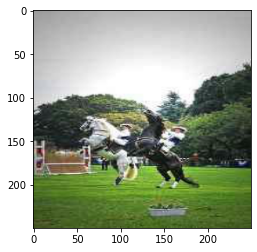

In [5]:
plt.imshow(data[1].permute(1, 2, 0))
plt.show()

In [7]:
x = torch.load("/Users/matteo/Documents/Università/Third_Year/Second_Semester/Deep_Learning/image_classification_with_caption/images_tensor_10000.pt")

In [10]:
for i in range(df_train.shape[0]):
    df_train.Labels[i] = [int(j) for j in df_train.Labels[i].split()]

In [11]:
max_i = 0
for i in df_train.Labels:
    max_i = max(max_i, max(i))

In [12]:
min_i = 19
for i in df_train.Labels:
    min_i = min(min_i, min(i))
min_i

1

In [13]:
for i in range(1, max_i+1):
    df_train[f'{i}'] = 0

In [14]:
for i in range(df_train.shape[0]):
    for j in df_train.Labels[i]:
        df_train[f"{j}"][i] = 1
df_train

/var/folders/wh/3gql38352135mch4hpd4c2s80000gn/T/ipykernel_1186/1723416721.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[f"{j}"][i] = 1


,ImageID,Labels,Caption,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,0.jpg,[1],Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.jpg,"[1, 19]",A couple of men riding horses on top of a gree...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.jpg,[1],They are brave for riding in the jungle on tho...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.jpg,"[8, 3, 13]",a black and silver clock tower at an intersect...,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4.jpg,"[8, 3, 7]",A train coming to a stop on the tracks out side.,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29991,29995.jpg,"[8, 1, 2]",A picture of a truck that is in the middle of ...,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29992,29996.jpg,[1],A plate topped with a pizza being cut with a s...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29993,29997.jpg,[1],A man riding a snowboard on top of snow.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29994,29998.jpg,[1],This photo shows people skiing in the mountains.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
